In [1]:
import pyclesperanto_prototype as cle
from skimage.io import imread
import napari_segment_blobs_and_things_with_membranes as nsbatwm
import napari_simpleitk_image_processing as nsitk
import napari_skimage_regionprops as nsr
import napari
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import umap
import seaborn

cle.get_device()

<gfx1035 on Platform: AMD Accelerated Parallel Processing (2 refs)>

In [2]:
image = imread("C:/structure/data/220214_crops/node_crop_small.tif")
image.shape

(181, 1134, 1134)

cl.OCLArray([[41., 63., 61., ..., 41., 39., 40.],
       [48., 54., 64., ..., 16., 26., 31.],
       [61., 60., 72., ..., 14., 44., 65.],
       ...,
       [67., 50., 39., ...,  1., 11., 14.],
       [66., 50., 67., ...,  0.,  0.,  4.],
       [75., 22., 54., ...,  0.,  0., 14.]], dtype=float32)
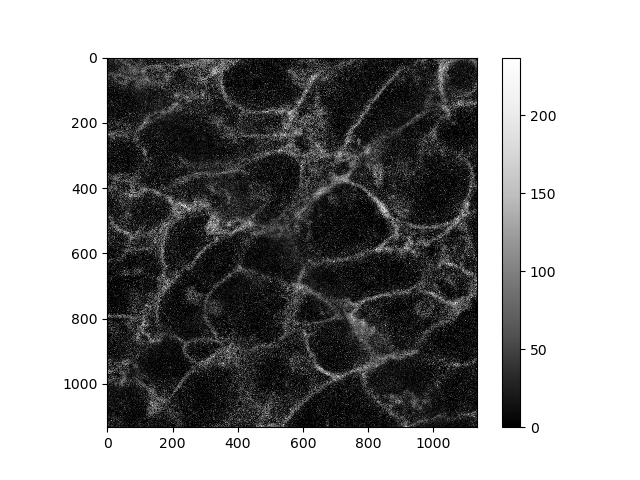
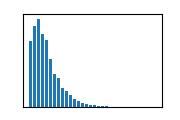

In [3]:
image2d = cle.asarray(image[90])
image2d

In [4]:
viewer = napari.Viewer()
viewer.add_image(image2d)

<Image layer 'image2d' at 0x20e76d81b80>

In [5]:
# gaussian blur
image2d_denoised = nsbatwm.gaussian_blur(image2d, 2.0)
viewer.add_image(image2d_denoised, name='Result of gaussian_blur')

# local minima seeded watershed
image2d_segmented = nsbatwm.local_minima_seeded_watershed(image2d_denoised, 25.0, 0.0)
viewer.add_labels(image2d_segmented, name='Result of local_minima_seeded_watershed')

<Labels layer 'Result of local_minima_seeded_watershed' at 0x20e76d190a0>

## 3D segmentation

cl.OCLArray([[[ 6.,  0.,  2., ...,  4.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  3.,  1.,  0.],
        ...,
        [ 4.,  0.,  1., ...,  0.,  0.,  0.],
        [ 0.,  8.,  4., ..., 18.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 3., 19.,  1., ...,  5.,  1.,  0.],
        [ 0.,  0.,  3., ...,  5.,  0.,  0.],
        [ 1.,  0.,  9., ..., 12.,  1.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  7.,  2.,  0.],
        [ 7.,  0.,  2., ...,  8., 21.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[15.,  7.,  4., ..., 10.,  0.,  0.],
        [ 5.,  4.,  6., ...,  3.,  0.,  0.],
        [ 1.,  3.,  2., ...,  0.,  9.,  0.],
        ...,
        [ 3.,  0.,  1., ...,  4., 34.,  0.],
        [ 0.,  0.,  0., ..., 22.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0., ...,  0.,  4.,  0.],
        [ 0.,  0.,  3., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  2.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 6.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  2., ...,  0.,  1.,  0.],
        [ 1.,  0.,  0., ...,  0., 10.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 2.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)
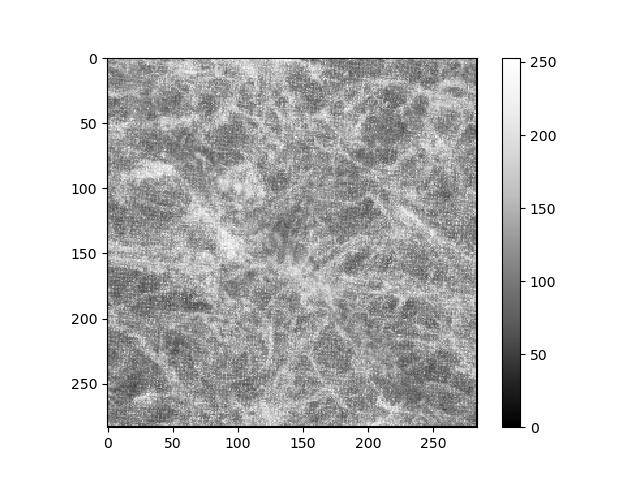
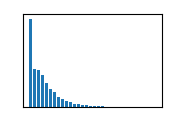

In [6]:
voxel_size_xy = 1
voxel_size_z = 5

zoom = 0.25

resampled = cle.scale(image, 
                         factor_x=voxel_size_xy*zoom, 
                         factor_y=voxel_size_xy*zoom, 
                         factor_z=voxel_size_z*zoom,
                        auto_size=True)
resampled

cl.OCLArray([[54., 60., 45., ..., 17.,  5.,  0.],
       [35., 21., 42., ...,  8., 31.,  0.],
       [39., 43., 40., ...,  5., 12.,  0.],
       ...,
       [ 2., 30., 42., ...,  6.,  0.,  0.],
       [ 0.,  3., 11., ..., 39., 10.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)
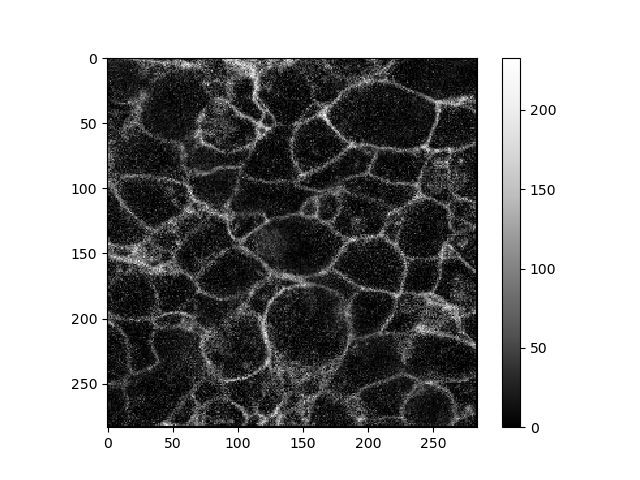
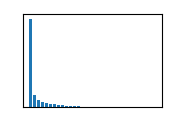

In [7]:
resampled[50]

In [8]:
viewer = napari.Viewer()
viewer.add_image(resampled)

<Image layer 'resampled' at 0x20e0a600070>

In [9]:
# gaussian blur
image3d_denoised = nsbatwm.gaussian_blur(resampled, 1)
viewer.add_image(image3d_denoised, name='Result of gaussian_blur')

# local minima seeded watershed
image3d_segmented = nsbatwm.local_minima_seeded_watershed(image3d_denoised, 5, 0.0 * zoom)
labels_layer = viewer.add_labels(image3d_segmented, name='Result of local_minima_seeded_watershed')

In [10]:
## Takes ages unfortunately:

#stats = nsitk.label_statistics(
#    intensity_image=resampled,
#    label_image=image3d_segmented,
#    intensity=True,
#    shape=True,
#    size=True)
#stats

In [11]:
stats = cle.statistics_of_labelled_pixels(resampled, image3d_segmented)
df = pd.DataFrame(stats)

labels_layer.properties = df
df

,label,original_label,bbox_min_x,bbox_min_y,bbox_min_z,bbox_max_x,bbox_max_y,bbox_max_z,bbox_width,bbox_height,...,centroid_z,sum_distance_to_centroid,mean_distance_to_centroid,sum_distance_to_mass_center,mean_distance_to_mass_center,standard_deviation_intensity,max_distance_to_centroid,max_distance_to_mass_center,mean_max_distance_to_centroid_ratio,mean_max_distance_to_mass_center_ratio
0,1,1,9.0,0.0,0.0,21.0,4.0,17.0,13.0,5.0,...,7.391645,2.007493e+03,5.241497,2.651352e+03,6.922590,42.876541,11.068810,15.594939,2.111765,2.252761
1,2,2,0.0,0.0,0.0,72.0,17.0,46.0,73.0,18.0,...,18.585106,2.227489e+05,16.058605,2.354933e+05,16.977388,40.937229,49.438412,44.085213,3.078624,2.596702
2,3,3,62.0,0.0,0.0,105.0,35.0,49.0,44.0,36.0,...,22.535835,2.216062e+05,15.315933,2.382235e+05,16.464409,40.366772,29.858849,35.911583,1.949529,2.181165
3,4,4,100.0,0.0,0.0,131.0,17.0,47.0,32.0,18.0,...,20.393763,9.025412e+04,13.216302,1.147853e+05,16.808514,44.977257,27.005095,36.516232,2.043317,2.172484
4,5,5,113.0,0.0,0.0,172.0,29.0,44.0,60.0,30.0,...,15.631280,2.147891e+05,15.070802,2.695846e+05,18.915564,32.812187,33.048668,40.854073,2.192894,2.159813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,659,659,66.0,243.0,137.0,186.0,283.0,225.0,121.0,41.0,...,190.019943,3.369168e+06,29.381678,4.025980e+06,35.109573,17.222424,79.040207,75.934006,2.690119,2.162772
659,660,660,151.0,257.0,175.0,204.0,283.0,225.0,54.0,27.0,...,209.560410,1.888256e+05,16.375471,2.552412e+05,22.135218,4.886645,35.212875,40.315472,2.150343,1.821327
660,661,661,113.0,226.0,149.0,259.0,283.0,225.0,147.0,58.0,...,188.768890,3.526550e+06,32.910126,4.087451e+06,38.144508,15.194738,80.689743,90.678459,2.451821,2.377235
661,662,662,217.0,256.0,202.0,266.0,283.0,225.0,50.0,28.0,...,219.131790,8.524593e+04,11.463949,8.550566e+04,11.498878,1.874103,31.137117,30.991465,2.716090,2.695173


In [12]:
nsr.add_table(labels_layer, viewer)

Napari status bar display of label properties disabled because https://github.com/napari/napari/issues/5417 and https://github.com/napari/napari/issues/4342


In [13]:
stats.keys()

dict_keys(['label', 'original_label', 'bbox_min_x', 'bbox_min_y', 'bbox_min_z', 'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_width', 'bbox_height', 'bbox_depth', 'min_intensity', 'max_intensity', 'sum_intensity', 'area', 'mean_intensity', 'sum_intensity_times_x', 'mass_center_x', 'sum_intensity_times_y', 'mass_center_y', 'sum_intensity_times_z', 'mass_center_z', 'sum_x', 'centroid_x', 'sum_y', 'centroid_y', 'sum_z', 'centroid_z', 'sum_distance_to_centroid', 'mean_distance_to_centroid', 'sum_distance_to_mass_center', 'mean_distance_to_mass_center', 'standard_deviation_intensity', 'max_distance_to_centroid', 'max_distance_to_mass_center', 'mean_max_distance_to_centroid_ratio', 'mean_max_distance_to_mass_center_ratio'])

In [14]:
selected_table = df[
    [
        'min_intensity', 
        'max_intensity', 
        'area', 
        'mean_intensity',
        #'standard_deviation_intensity',
        #'mean_max_distance_to_centroid_ratio', 
        #'mean_max_distance_to_mass_center_ratio'
    ]
]

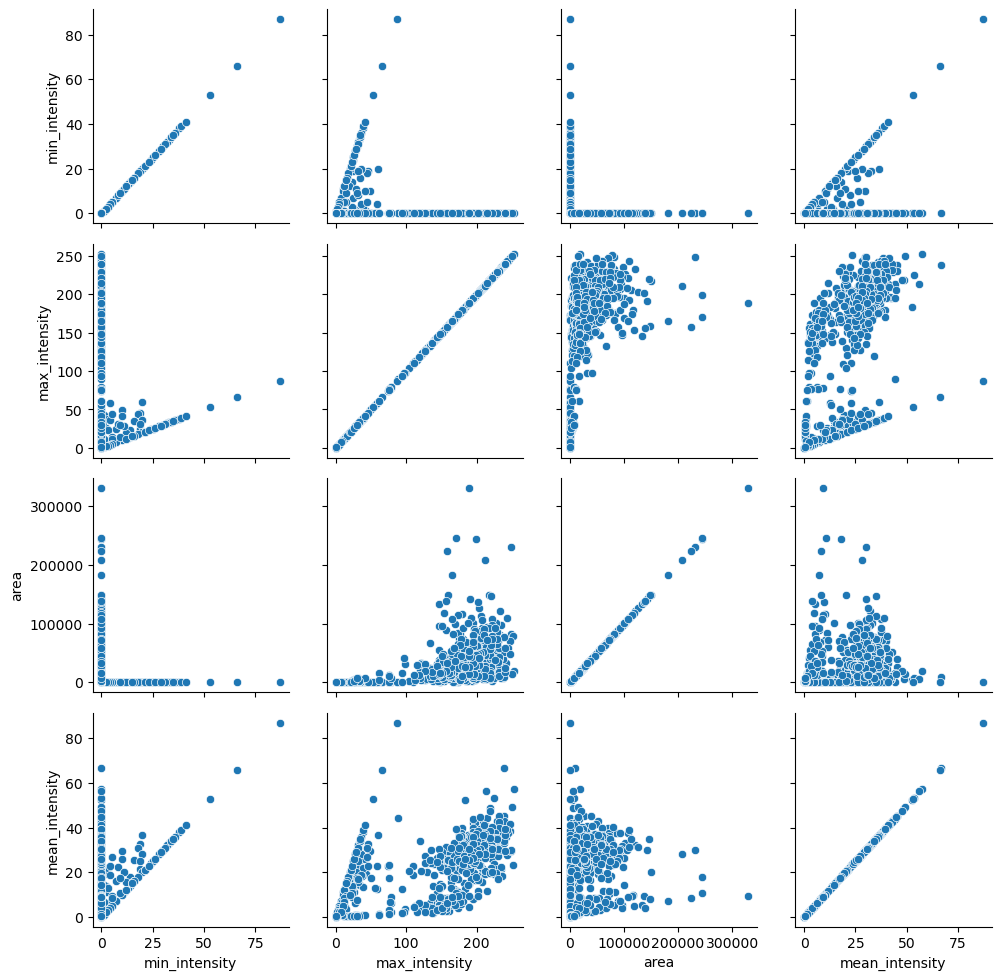

In [16]:
g = seaborn.PairGrid(selected_table)
g.map(seaborn.scatterplot)

In [17]:
selected_table = df[
    [
        'min_intensity', 
        'max_intensity', 
        'area', 
        'mean_intensity',
        #'standard_deviation_intensity',
        #'mean_max_distance_to_centroid_ratio', 
        #'mean_max_distance_to_mass_center_ratio'
    ]
]

selected_statistics = selected_table.values

In [18]:
scaled_statistics = StandardScaler().fit_transform(selected_statistics)

type(scaled_statistics), scaled_statistics.shape

(numpy.ndarray, (663, 4))

In [19]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_statistics)
type(embedding), embedding.shape

(numpy.ndarray, (663, 2))

<AxesSubplot: >

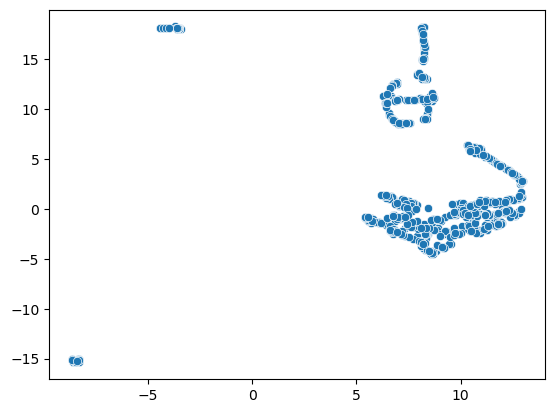

In [20]:
seaborn.scatterplot(x=embedding[:, 0], 
                    y=embedding[:, 1])

In [21]:
df["UMAP1"] = embedding[:, 0]
df["UMAP2"] = embedding[:, 1]

labels_layer.features = df